<a href="https://colab.research.google.com/github/dvmorris/coca-image-embedding/blob/master/Build_Cloud_CoCa_Image_Embedding_Dataset_%26_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2023 Google LLC.

SPDX-License-Identifier: Apache-2.0

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Overview

This Colab demonstrates CoCa image embedding (https://arxiv.org/abs/2205.01917) inference end-to-end, including getting embedding from both image and text, indexing the embedding and search using either ScaNN or Vertex Matching Engine.

The information in this documentation is provided to the customer on an “as is” and “with all faults” basis without any warranty of any kind, either express or implied. Google does not warrant or guarantee the correctness, accuracy or reliability of the information in here. In no event will Google or its affiliates or licensors be liable for any damage or harm to customers from customer’s use of these materials.

Author: wuxiao@google.com

# Section 0: Preparation



---



This is to set up shared functions and import shared packages for the remaining of the Colab to complete. Please execute this section every time the runtime get resets.

Note: The installation may complain some version conflicts. Seems OK to ignore.

In [1]:
# does not work in Argolis
# !gsutil cp gs://vertex-ai-allowlist/generative-ai/vision/multimodalembedding/requirements.txt .
# !pip3 install -r requirements.txt

!pip3 install absl-py==1.4.0
!pip3 install google-cloud-aiplatform==1.25.0
!pip3 install proto-plus==1.22.2
!pip3 install protobuf==4.23.0

!pip install scann

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.5 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.1
    Uninstalling shapely-2.0.1:
      Successfully uninstalled shapely-2.0.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 20.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 

## Step 0.0: Define embedding calculation functions. Both image embedding and text embedding calculators are defined below.

The embedding extraction is served from Vertex AI. Please enable that at your Cloud Console or run `gcloud services enable aiplatform.googleapis.com --project {your_project}`.

Use of the API requires allowlisting. Please follow the Prerequisite section in https://docs.google.com/document/d/1UdJSN3I1XfF97g1Ocukse89eaMSksVXGzfFjximPKgs/edit#heading=h.d8qh4jlew6dg to get allowlisted.

In [2]:
import base64
from google.cloud import storage
from google.cloud import aiplatform
from google.protobuf import struct_pb2
import sys
import time
import typing

PROJECT_ID = 'gen-ai-demo-davemorris-2023' # @param {type: "string"}

# Inspired from https://stackoverflow.com/questions/34269772/type-hints-in-namedtuple.
class EmbeddingResponse(typing.NamedTuple):
  text_embedding: typing.Sequence[float]
  image_embedding: typing.Sequence[float]

class EmbeddingPredictionClient:
  """Wrapper around Prediction Service Client."""
  def __init__(self, project : str,
    location : str = "us-central1",
    api_regional_endpoint: str = "us-central1-aiplatform.googleapis.com"):
    client_options = {"api_endpoint": api_regional_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    self.client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    self.location = location
    self.project = project

  def get_embedding(self, text : str = None, image_bytes : bytes = None):
    if not text and not image_bytes:
      raise ValueError('At least one of text or image_bytes must be specified.')

    instance = struct_pb2.Struct()
    if text:
      instance.fields['text'].string_value = text

    if image_bytes:
      encoded_content = base64.b64encode(image_bytes).decode("utf-8")
      image_struct = instance.fields['image'].struct_value
      image_struct.fields['bytesBase64Encoded'].string_value = encoded_content

    instances = [instance]
    endpoint = (f"projects/{self.project}/locations/{self.location}"
      "/publishers/google/models/multimodalembedding@001")
    response = self.client.predict(endpoint=endpoint, instances=instances)

    text_embedding = None
    if text:
      text_emb_value = response.predictions[0]['textEmbedding']
      text_embedding = [v for v in text_emb_value]

    image_embedding = None
    if image_bytes:
      image_emb_value = response.predictions[0]['imageEmbedding']
      image_embedding = [v for v in image_emb_value]

    return EmbeddingResponse(
      text_embedding=text_embedding,
      image_embedding=image_embedding)

client = EmbeddingPredictionClient(project=PROJECT_ID)

# Extract image embedding
def getImageEmbeddingFromImageContent(content):
  response = client.get_embedding(text=None, image_bytes=content)
  return response.image_embedding

def getImageEmbeddingFromGcsObject(gcsBucket, gcsObject):
  client = storage.Client()
  bucket = client.bucket(gcsBucket)
  blob = bucket.blob(gcsObject)

  with blob.open("rb") as f:
    return getImageEmbeddingFromImageContent(f.read())

def getTextEmbeddingFromGcsObject(gcsBucket, gcsObject):
  client = storage.Client()
  bucket = client.bucket(gcsBucket)
  blob = bucket.blob(gcsObject)

  with blob.open("r") as f:
    return getTextEmbedding(f.read())

def getImageEmbeddingFromFile(filePath):
  with open(filePath, "rb") as f:
    return getImageEmbeddingFromImageContent(f.read())

# Extract text embedding
def getTextEmbedding(text):
  response = client.get_embedding(text=text, image_bytes=None)
  return response.text_embedding


## Step 0.1: Authenticate yourself.

As downstream references GCP services (e.g. GCS) in almost all sections, please get yourself authenticated so you can access the services without getting 403 (Access Denied).

In [3]:
from google.colab import auth as google_auth

google_auth.authenticate_user()

# Section 1: Build CoCa image embedding dataset.


---

This section calculates the CoCa image embeddings for a set of images stored in GCS. The number of images in the dataset is less than 100 so we are calculating the embedding in sequence. For larger datasets, please use Dataflow to improve the parallelism.

The image dataset is contributed by the engineering team.

In [ ]:
from google.cloud import storage
import csv
import time
# This is the GCS bucket that holds the images that you want to analyze and
# index. You will need the bucket list and object reading permission to proceed.
# The default bucket provided here contains 61 images contributed by the
# engineer team. If you want to try your own image set, feel free to point this
# to another GCS bucket that holds your images. Please make sure all files in
# the GCS bucket are images (e.g. JPG, PNG). Non image files would cause
# inference exception down below.
IMAGE_SET_BUCKET_NAME = "gen-ai-demo-davemorris-2023" # @param {type: "string"}

gcsBucket = storage.Client().get_bucket(IMAGE_SET_BUCKET_NAME)
ids = []

with open('image_embedding.csv', 'r') as f:
  reader = csv.reader(f, delimiter=',')
  for row in reader:
    ids.append(row[0].split('/')[-1].split('.')[0])

with open('image_embedding.csv', 'a') as f:
  csvWriter = csv.writer(f)
  csvWriter.writerow(['gcsUri', 'embedding'])
  prefix='grocery-product-images/group1/'
  for blob in gcsBucket.list_blobs(prefix=prefix):
    if blob.name.split('/')[-1].split('.')[0] not in ids:
      gcsUri = "gs://" + IMAGE_SET_BUCKET_NAME + '/' + blob.name
      print("Processing {}".format(gcsUri))
      embedding = getImageEmbeddingFromGcsObject(IMAGE_SET_BUCKET_NAME, blob.name)
      time.sleep(1)
      csvWriter.writerow([gcsUri, str(embedding)])

As the image embedding calculation can take long, we can save the generated image_embedding.csv locally so we can start section 2 later on in a separate session.

In [ ]:
from google.cloud import storage
import csv
import time
# This is the GCS bucket that holds the text files that you want to analyze and
# index. You will need the bucket list and object reading permission to proceed.
TEXT_SET_BUCKET_NAME = "gen-ai-demo-davemorris-2023" # @param {type: "string"}

gcsBucket = storage.Client().get_bucket(TEXT_SET_BUCKET_NAME)
ids = []

with open('text_embedding.csv', 'r') as f:
  reader = csv.reader(f, delimiter=',')
  for row in reader:
    ids.append(row[0].split('/')[-1].split('.')[0])

with open('text_embedding.csv', 'a') as f:
  csvWriter = csv.writer(f)
  csvWriter.writerow(['gcsUri', 'embedding'])
  prefix='grocery-product-titles/group1/'
  for blob in gcsBucket.list_blobs(prefix=prefix):
    if blob.name.split('/')[-1].split('.')[0] not in ids:
      gcsUri = "gs://" + TEXT_SET_BUCKET_NAME + '/' + blob.name
      print("Processing {}".format(gcsUri))
      embedding = getTextEmbeddingFromGcsObject(TEXT_SET_BUCKET_NAME, blob.name)
      time.sleep(1)
      csvWriter.writerow([gcsUri, str(embedding)])

In [ ]:
from google.colab import files

files.download('image_embedding.csv')
files.download('text_embedding.csv')

# Section 2: Zero shot image search by text or image similarity.

---
This section searches the images by either ScaNN or Vertex Matching Engine. Text embedding is calculated using getTextEmbedding() defined in Section 0.
Image embedding is calculated using getImageEmbeddingFromFile() defined in Section 0 too.


## Section 2.0: Preparation

### Step 2.0.0: Upload the image_embedding.csv from where you uploaded to at the end of section 1.

If you are directly doing after section 1 without restarting the runtime, the file existance check will skip the file upload automatically.

In [ ]:
from google.colab import files
import os

if not os.path.exists('image_embedding.csv'):
  print("Upload your saved image_embedding.csv")

  uploaded = files.upload()

  found_file = False
  for filename in uploaded.keys():
    print(uploaded)
    if filename == "image_embedding.csv":
      print("Found your image_embedding.csv")
      found_file = True

  if not found_file:
    raise ValueError("No image_embedding.csv uploaded")

Load the image embedding file to pandas.

In [3]:
import pandas as pd
import numpy as np

# df = pd.read_csv('image_embedding.csv', nrows=3480)
df = pd.read_csv('image_embedding.csv')

# ERROR: ValueError: Columns must be same length as key
df.embedding = df.embedding.apply(eval).apply(np.array)

df.head(5)

,gcsUri,embedding
0,gs://gen-ai-demo-davemorris-2023/grocery-produ...,"[0.017014714, 0.00717118615, 0.0017492373, 0.0..."
1,gs://gen-ai-demo-davemorris-2023/grocery-produ...,"[-0.000758294191, 0.0130682895, 0.0249046609, ..."
2,gs://gen-ai-demo-davemorris-2023/grocery-produ...,"[0.0184799023, 0.0107856765, 0.0142408656, 0.0..."
3,gs://gen-ai-demo-davemorris-2023/grocery-produ...,"[-0.00370293227, 0.00963833835, 0.0262256, 0.0..."
4,gs://gen-ai-demo-davemorris-2023/grocery-produ...,"[0.00973343849, 0.0131002599, -0.0115548549, 0..."


### Step 2.0.1: Define a helper function to search image by text.

It does the following in order:

1. calculate the text embedding
2. search the embedding from the search backend (ScaNN or VME), and get top 3 closest neighbors.
3. Display the search results and the corresponding images.

In [4]:
from pandas.io.parsers.readers import ParserBase
import time
import re
import cv2
from google.colab.patches import cv2_imshow
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image

def img_reshape(img):
    img = Image.open(img).convert('RGB')
    img = img.resize((300,300))
    img = np.asarray(img)
    return img

def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

# @@search_backend_function is a function that takes two parameters
#   @@embedding_vector: a embedding vector to search against.
#   @@num_neighbors: number of neighbors to return from the backend.
# and it returns two things
#   @@neighbors: a list of ids (0 based position in the dataset) indicating the
#                neighbors that's closest to the input embedding_vector.
#   @@distances: a list of distances, each corresponding to the distance from
#                the @@embedding_vector to the data point int he dataset,
#                indexed by the corresponding id in @@neighbor.
def searchImagesByEmbedding(start_time, embedding, search_backend_function,
                            num_neighbors = 6):
    neighbors, distances = search_backend_function(
        embedding, num_neighbors)
    end = time.time()

    gcsClient = storage.Client()
    img_arr = []
    id_arr = []
    for id, dist in zip(neighbors, distances):
        print(f'docid:{id} dist:{dist} gcsUri:{df.gcsUri[id]}')
        # Display the image
        gcsUri = df.gcsUri[id]
        m = re.search('gs://([^/]*)/([^$]*)', gcsUri)
        imageBlob = gcsClient.get_bucket(m[1]).blob(m[2])
        tmpFilename = "/tmp/" + m[2].split('/')[-1]
        id_arr.append(m[2].split('/')[-1].split('.')[0])
        imageBlob.download_to_filename(tmpFilename)
        img_arr.append(img_reshape(tmpFilename))
        # image = cv2.imread(tmpFilename, -1)
        # cv2_imshow(image)

    rows = 2
    cols = 3
    img_count = 0
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))
    for i in range(rows):
        for j in range(cols):
            axes[i, j].axis('off')

    for i in range(rows):
        for j in range(cols):
            if img_count < len(img_arr):
                axes[i, j].set_title(id_arr[img_count])
                axes[i, j].imshow(img_arr[img_count])
                img_count+=1

    print("Latency (ms):", 1000*(end - start_time))

def searchImagesByText(query, search_backend_function, num_neighbors = 6):
    start_time = time.time()
    query_embedding = getTextEmbedding(query)
    return searchImagesByEmbedding(start_time, query_embedding,
                                   search_backend_function)

def searchImagesByUploadedImages(search_backend_function, num_neighbors = 6):
    uploaded = files.upload()
    for filename in uploaded.keys():
      print('Searching images similar to {}'.format(filename))
      image = cv2.imread(filename, -1)
      resize = ResizeWithAspectRatio(image, width=400) # Resize by width OR
      cv2_imshow(resize)
      start_time = time.time()
      image_embedding = getImageEmbeddingFromFile(filename)
      searchImagesByEmbedding(start_time, image_embedding,
                              search_backend_function, num_neighbors)


### Section 2.1 and Section 2.2 shows how to search using ScaNN and VME respectively. You can try one of them, or both. If you want to try search using VME directly, please jump to Section 2.2.

## Section 2.1: Search using ScaNN.

### Step 2.1.0: Construct the dataset that ScaNN consumes as the input. And then define the function to search against it.

In [5]:
import scann
import numpy as np
import pandas as pd

# df.shape[0] is the #data in the dataset.
# df.embedding[0].size is the embedding vector size.
dataset = np.empty((df.shape[0], df.embedding[0].size))
for i in range(df.shape[0]):
  dataset[i] = df.embedding[i]

searcher = scann.scann_ops_pybind.builder(dataset, 10, "dot_product").tree(
    num_leaves=10, num_leaves_to_search=10).score_ah(2).reorder(100).build()

def searchByScaNN(embedding_vector, num_neighbors):
    return searcher.search(
        embedding_vector, final_num_neighbors = num_neighbors)

### Step 2.1.1: Search

You can either do search by text, or search by image. Search by image is not the advantages of CoCa model, so here just shows you its capability.

docid:5472 dist:0.06410238891839981 gcsUri:gs://gen-ai-demo-davemorris-2023/grocery-product-images/group1/149210.jpg
docid:5068 dist:0.06242838874459267 gcsUri:gs://gen-ai-demo-davemorris-2023/grocery-product-images/group1/145132.jpg
docid:2082 dist:0.06075545772910118 gcsUri:gs://gen-ai-demo-davemorris-2023/grocery-product-images/group1/124098.jpg
docid:1417 dist:0.05991722270846367 gcsUri:gs://gen-ai-demo-davemorris-2023/grocery-product-images/group1/119373.jpg
docid:1429 dist:0.059469737112522125 gcsUri:gs://gen-ai-demo-davemorris-2023/grocery-product-images/group1/119392.jpg
docid:2421 dist:0.0594584085047245 gcsUri:gs://gen-ai-demo-davemorris-2023/grocery-product-images/group1/125703.jpg
Latency (ms): 148.83708953857422


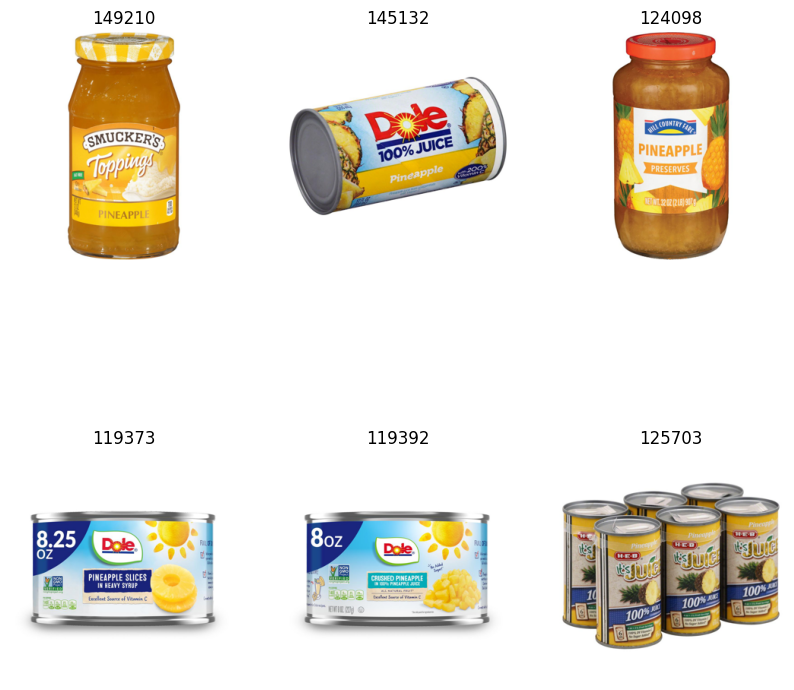

In [17]:
# Search by text. Modify the query and execute to see the search result.
searchImagesByText("pineapple", searchByScaNN)

Saving PXL_20230623_033058479.jpg to PXL_20230623_033058479 (1).jpg
Searching images similar to PXL_20230623_033058479.jpg


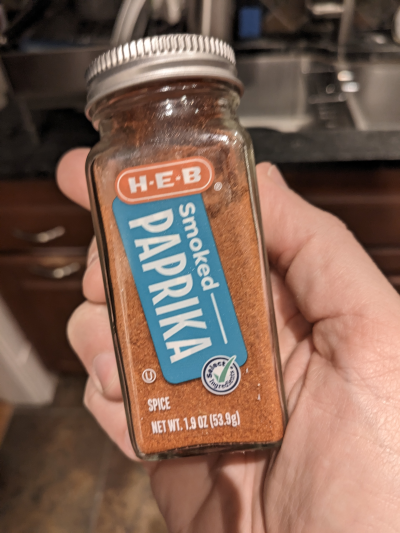

docid:5637 dist:0.8593988418579102 gcsUri:gs://gen-ai-demo-davemorris-2023/grocery-product-images/group1/149972.jpg
docid:1707 dist:0.82990562915802 gcsUri:gs://gen-ai-demo-davemorris-2023/grocery-product-images/group1/121749.jpg
docid:5696 dist:0.8240289092063904 gcsUri:gs://gen-ai-demo-davemorris-2023/grocery-product-images/group1/150058.jpg
docid:3299 dist:0.823146641254425 gcsUri:gs://gen-ai-demo-davemorris-2023/grocery-product-images/group1/128594.jpg
docid:4513 dist:0.8213679194450378 gcsUri:gs://gen-ai-demo-davemorris-2023/grocery-product-images/group1/139530.jpg
docid:5624 dist:0.8182916045188904 gcsUri:gs://gen-ai-demo-davemorris-2023/grocery-product-images/group1/149957.jpg
Latency (ms): 6066.617250442505


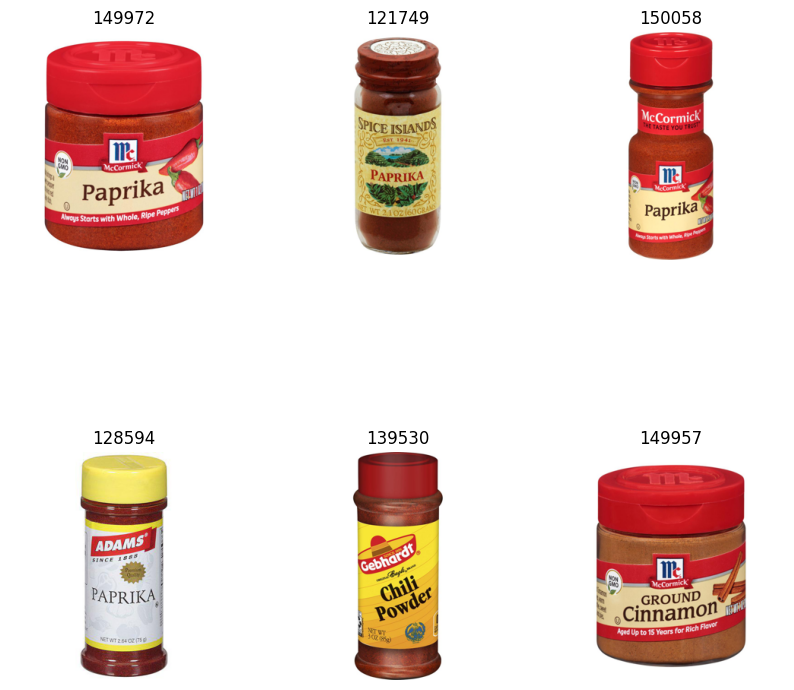

In [6]:
# Search by image. Upload your own image and search.
searchImagesByUploadedImages(searchByScaNN)

## Section 2.2: Search using Vertex Matching Engine.

Please note that using Vertex Matching Engine for embedding search would incur cost to your GCP project.

### Step 2.2.0: Define a set of constants used by downstream.

In [ ]:
REGION = 'us-central1' # @param {type: "string"}

! gcloud config set project {PROJECT_ID}

ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)

PROJECT_NUMBER = !gcloud projects list --filter="PROJECT_ID:'{PROJECT_ID}'" --format='value(PROJECT_NUMBER)'
PROJECT_NUMBER = PROJECT_NUMBER[0]

PARENT = "projects/{}/locations/{}".format(PROJECT_ID, REGION)

# Bucket for holding the indexing data for VME. You will need the bucket
# writing permission to proceed.
INDEX_DATA_BUCKET_NAME = '' # @param {type: "string"}

! gsutil mb -l $REGION -p $PROJECT_ID gs://{INDEX_DATA_BUCKET_NAME}
! gsutil rm -raf gs://{INDEX_DATA_BUCKET_NAME}/** 2> /dev/null || true

### Step 2.2.1: Convert the image embedding into the JSON format that VME recognizes.

The idx is the position of the data point in the dataset.

After conversion, upload the JSON file to a empty GCS bucket so VME can consume.

In [ ]:
import json

with open('image_embedding.json', 'w') as f:
  for idx, embedding in enumerate(df.embedding):
    json.dump({"id": idx, "embedding": embedding.tolist()}, f)
    f.write('\n')

! gsutil cp image_embedding.json gs://{INDEX_DATA_BUCKET_NAME}/image_embedding.json

### Step 2.2.2: Create VME index from the dataset. The index creation may take ~30 minutes.

In [ ]:
import time
from google.cloud import aiplatform_v1beta1
from google.protobuf import struct_pb2

DIMENSIONS = df.embedding[0].size
DISPLAY_NAME = "image-embedding"

index_client = aiplatform_v1beta1.IndexServiceClient(
    client_options=dict(api_endpoint=ENDPOINT)
)

treeAhConfig = struct_pb2.Struct(
    fields={
        "leafNodeEmbeddingCount": struct_pb2.Value(number_value=df.shape[0]),
        "leafNodesToSearchPercent": struct_pb2.Value(number_value=7),
    }
)

algorithmConfig = struct_pb2.Struct(
    fields={"treeAhConfig": struct_pb2.Value(struct_value=treeAhConfig)}
)

config = struct_pb2.Struct(
    fields={
        "dimensions": struct_pb2.Value(number_value=DIMENSIONS),
        "approximateNeighborsCount": struct_pb2.Value(number_value=10),
        "distanceMeasureType": struct_pb2.Value(string_value="DOT_PRODUCT_DISTANCE"),
        "algorithmConfig": struct_pb2.Value(struct_value=algorithmConfig),
    }
)

metadata = struct_pb2.Struct(
    fields={
        "config": struct_pb2.Value(struct_value=config),
        "contentsDeltaUri": struct_pb2.Value(string_value="gs://{}".format(INDEX_DATA_BUCKET_NAME)),
    }
)

matching_engine_index = {
    "display_name": DISPLAY_NAME,
    "description": "Google Products Vertex AI Matching Engine Index",
    "metadata": struct_pb2.Value(struct_value=metadata),
}

# Create the index and wait for it to be ready.
matching_engine_index_operation = index_client.create_index(
    parent=PARENT, index=matching_engine_index
)

while not matching_engine_index_operation.done():
    print("Poll the operation to create index...")
    time.sleep(60)

INDEX_RESOURCE_NAME = matching_engine_index_operation.result().name
print("Index created: {}".format(INDEX_RESOURCE_NAME))

### Step 2.2.3: Create Index Endpoint.

Create an index endpoint so that we can deploy the index to. This usually takes a few minutes.

In [ ]:
index_endpoint_client = aiplatform_v1beta1.IndexEndpointServiceClient(
    client_options=dict(api_endpoint=ENDPOINT)
)

index_endpoint = {
    "display_name": "coca_image_index_endpoint",
    "public_endpoint_enabled": True,
}

index_endpoint_operation = index_endpoint_client.create_index_endpoint(
    parent=PARENT, index_endpoint=index_endpoint
)

while not index_endpoint_operation.done():
    print("Poll the operation to create index endpoint...")
    time.sleep(60)

INDEX_ENDPOINT_NAME = index_endpoint_operation.result().name
print("Index endpoint created: {}".format(INDEX_ENDPOINT_NAME))

index_endpoint = index_endpoint_client.get_index_endpoint(
    name = INDEX_ENDPOINT_NAME)

INDEX_ENDPOINT_PUBLIC_DOMAIN_NAME = index_endpoint.public_endpoint_domain_name

print("Index endpoint public domain name: {}".format(
    INDEX_ENDPOINT_PUBLIC_DOMAIN_NAME))

### Step 2.2.4: Deploy the index to the endpoint.

This usually takes ~15 minutes.

In [ ]:
DEPLOYED_INDEX_ID = "coca_image_embedding_deployment" # @param {type: "string"}

deploy_matching_engine_index = {
    "id": DEPLOYED_INDEX_ID,
    "display_name": DEPLOYED_INDEX_ID,
    "index": INDEX_RESOURCE_NAME,
}

deploy_index_operation = index_endpoint_client.deploy_index(
    index_endpoint=INDEX_ENDPOINT_NAME, deployed_index=deploy_matching_engine_index
)

while not deploy_index_operation.done():
    print("Poll the operation to deploy index...")
    time.sleep(60)

deploy_index_operation.result()

### Step 2.2.5: Define the function that searches against VME.

In [ ]:
from proto.fields import RepeatedField, ProtoType
from google.cloud.aiplatform_v1beta1 import MatchServiceClient, IndexDatapoint, FindNeighborsRequest, FindNeighborsResponse

match_service_client = MatchServiceClient(
    client_options=dict(api_endpoint=INDEX_ENDPOINT_PUBLIC_DOMAIN_NAME)
)

def searchByVertexMatchingEngine(embedding_to_search, neighbor_count):
  datapoint = IndexDatapoint(
      feature_vector = embedding_to_search
  )

  query = FindNeighborsRequest.Query(
      datapoint = datapoint,
      neighbor_count = neighbor_count
  )

  find_neighbors_request = FindNeighborsRequest(
      index_endpoint = INDEX_ENDPOINT_NAME,
      deployed_index_id = DEPLOYED_INDEX_ID,
      queries = [query],
  )

  response = match_service_client.find_neighbors(
      request = find_neighbors_request)

  neighbors = []
  distances = []
  for neighbor in response.nearest_neighbors[0].neighbors:
    neighbors.append(int(neighbor.datapoint.datapoint_id))
    distances.append(neighbor.distance)

  return neighbors, distances


### Step 2.2.8: Search

You can either do search by text, or search by image. Search by image is not the advantages of CoCa model, so here just shows you its capability.

In [ ]:
# Search by text. Modify the query and execute to see the search result.
searchImagesByText("lake view", searchByVertexMatchingEngine)

In [ ]:
# Search by image. Upload your own image and search.
searchImagesByUploadedImages(searchByVertexMatchingEngine)

### Step 2.2.9: Cleanup

Clean up the resource that's allocated for the Colab, including index, endpoint and the deployment. We need to clean them up in the reverse order, meaning, we first undeploy the index, then delete the index endpoint, and finally delete the index.

We are not tracking the completion of the operations here, assuming they will be cleaned up eventually.

In [ ]:
index_endpoint_client.undeploy_index(index_endpoint=INDEX_ENDPOINT_NAME,
                                     deployed_index_id=DEPLOYED_INDEX_ID)

index_endpoint_client.delete_index_endpoint(name=INDEX_ENDPOINT_NAME)

index_client.delete_index(name=INDEX_RESOURCE_NAME)